# Analyse Data

Note, you want to analyse the remaining data with a monotonic predictor, e.g. https://github.com/junpenglao/Planet_Sakaar_Data_Science/blob/main/Ports/brms_monotonic_compare.ipynb

See also this on combining predictors: https://discourse.pymc.io/t/how-to-build-brms-monotonic-model-with-additional-predictor/4912

You want a continuous and monotonic predictor in the model.

In [12]:
# Import libraries
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pymc as pm
import pandas as pd
import os
import aesara
import aesara.tensor as at
import warnings

In [2]:
print(f"We used Python version {sys.version} and the Python packages PyMC v{pm.__version__}, arviz v{az.__version__}, numpy v{np.__version__}, pandas v{pd.__version__}, aesara v{aesara.__version__}, and seaborn v{sns.__version__} for all data processing, analysis, and presentation")

We used Python version 3.9.5 (default, May  4 2021, 03:36:27) 
[Clang 12.0.0 (clang-1200.0.32.29)] and the Python packages PyMC v4.0.0b2, arviz v0.11.4, numpy v1.21.5, pandas v1.4.1, aesara v2.3.8, and seaborn v0.11.2 for all data processing, analysis, and presentation


First we read in the data, removing participant 15 who did not suffer from brain injury but took part regardless.

In [3]:
# set options
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')
warnings.filterwarnings('ignore') # suppress warnings

In [15]:
# read data, remove P15, fix data types
dat = pd.read_csv('../data/cleaned-results.csv').query('PID != "P15"').convert_dtypes() 

Next, we create the monotonic preedictor from the De Jong Grieveld categories present in the data.

In [287]:
# make DJG a monotonic effect. This generates the simplex monotinic (simo) categories for DJG.
# note that you have to set the lowest category to 0 (here ours was 2, 3, 4; hence now 0, 1, 2)
X = np.array(dat.DJG) - 2 
ncat = len(np.unique(X))
df = ncat -1
con_simo_1 = np.ones(df)

Xmo = np.zeros((len(X), ncat), int)
for ic, i in enumerate(X):
    if i > 0:
        Xmo[ic, :i+1] = np.arange(i + 1)

With only limited range of BRS scores, we collapse this into a category of "low" (-1) and "normal-to-high" (+1), with this cutoff for grouoping set at 2.99. Note that the high category was collapsed into the normal category as this only had one observation. 

In [288]:
dat['BRS_cat'] = np.asarray(np.where(dat['BRS'] < 2.99, -1, 1)) # difference coding

First, we defined our maximal model. This takes the form of a Bayesian model estimating monotonic effects of the De Jong Grieveld (DJG) predictor and with the categorical predictor of Brief Resilience Scale (BRS) category. The DJG predictor is estimated using monotonic effects as effects are assumed to have a monotonically increasing relationship with the response, and because this predictor is made up of a limited range of categories which cannot be assumed to be linearly related nor can be assumed to be unrelated categories (Burkner & Charpentier, 2020). Indeed, Burkner and Charpenier note that this model specification is particularly useful with Likert-scale data. 

The model thus captures and summarises the monotinic effects in terms of two parameters: $\hat{\beta}$ estimaging the magnitude and direction of effect as with typical regression parameter estimates, and $\zeta$ which is a vector estimating the normalised distances between consecutive categories in the predictor. However, given that the BRS only has 3 categories -- low, medium, and high -- and we have only 1 observation in the high category we collaped this predictor into a simple categorical predictor with the categories low and medium-high. The categorical predictor of BRS was sum-coded (low = -1, medium-high = 1) prior to model fitting. With this model specification, the intercept represents the grand mean collapsed across BRS categories. 

This model used a *Student-t*(3, 46, 11.9) prior on the intercept, a *Normal*(0, 5) prior on the DJG monotonic predictors, a *Normal*(0, 20) prior on the BRS predictor, a *Drichlet*(1) prior on each of the 3 simplex monotonic categories, and a *Cauchy<sub>+</sub>*(10) for the standard deviation term. We compared this model with three other possible models: one removing the effect of DJG, one removing the effect of BRS, and one removing the effects for both DJG and BRS. Model comparison was performed using Pareto-smoothed importance sampling leave-one-out cross-validation (PSIS-LOO-CV) to establish which of these models is most consistent with our data.

In [289]:
a = aesara.shared(np.zeros(1,))
with pm.Model() as fit1:
    intercept = pm.StudentT('intercept', mu=3, sigma=46, nu=11.9)
    beta_DJG = pm.Normal('beta_DJG', mu=0., sigma=5.)
    beta_BRS = pm.Normal('beta_BRS', mu=0., sigma=20.)
    sigma = pm.HalfCauchy("sigma", beta=10, testval=1.0)

    simo_1 = pm.Dirichlet('simo_1', a=con_simo_1)
    simo = at.concatenate([a, simo_1])
    
    mu = intercept + beta_BRS * np.asarray(dat.BRS_cat) + beta_DJG * at.sum(simo[Xmo], axis=1)
    obs = pm.Normal('Y', mu=mu, sigma=sigma, observed=dat['WEMWBS'].values)
    trace1 = pm.sample(3000, return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_DJG, beta_BRS, sigma, simo_1]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 26 seconds.


In [290]:
with pm.Model() as fit2:
    intercept = pm.StudentT('intercept', mu=3, sigma=46, nu=11.9)
    beta_BRS = pm.Normal('beta_BRS', mu=0., sigma=20.)
    sigma = pm.HalfCauchy("sigma", beta=10, testval=1.0)
    mu = intercept + beta_BRS * np.asarray(dat.BRS_cat)
    obs = pm.Normal('Y', mu=mu, sigma=sigma, observed=dat['WEMWBS'].values)
    trace2 = pm.sample(3000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_BRS, sigma]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 16 seconds.


In [291]:
with pm.Model() as fit3:
    intercept = pm.StudentT('intercept', mu=3, sigma=46, nu=11.9)
    beta_DJG = pm.Normal('beta_DJG', mu=0., sigma=5.)
    sigma = pm.HalfCauchy("sigma", beta=10, testval=1.0)

    simo_1 = pm.Dirichlet('simo_1', a=con_simo_1)
    simo = at.concatenate([a, simo_1])
    
    mu = intercept + beta_DJG * at.sum(simo[Xmo], axis=1)
    obs = pm.Normal('Y', mu=mu, sigma=sigma, observed=dat['WEMWBS'].values)
    trace3 = pm.sample(3000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_DJG, sigma, simo_1]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 23 seconds.


In [292]:
with pm.Model() as fit4:
    intercept = pm.StudentT('intercept', mu=3, sigma=46, nu=11.9)
    sigma = pm.HalfCauchy("sigma", beta=10, testval=1.0)
    mu = intercept
    obs = pm.Normal('Y', mu=mu, sigma=sigma, observed=dat['WEMWBS'].values)
    trace4 = pm.sample(3000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, sigma]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 15 seconds.


In [293]:
comp_loo = az.compare({"full": trace1, "BRS-only": trace2, "DJG-only": trace3, "intercept-only": trace4})
comp_loo

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
full,0,-88.432053,3.284063,0.000000,9.041014e-01,3.987253,0.000000,False,log
BRS-only,1,-88.871063,2.735202,0.439010,1.507893e-16,3.562143,0.696751,False,log
DJG-only,2,-92.458346,2.015601,4.026292,0.000000e+00,3.124724,3.034264,False,log
intercept-only,3,-92.583909,1.726863,4.151855,9.589863e-02,3.035528,3.092895,False,log


<AxesSubplot:xlabel='Log'>

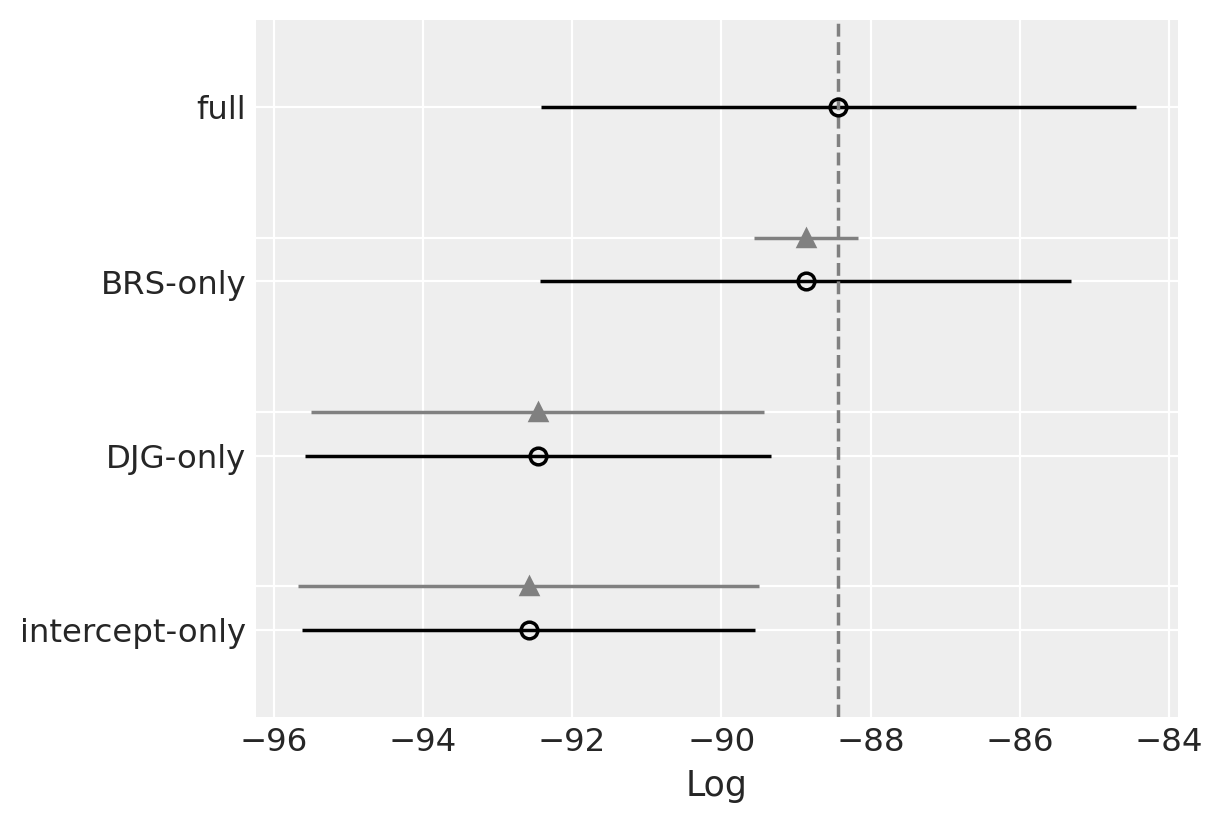

In [294]:
az.plot_compare(comp_loo, insample_dev = False)

This showed practically no difference between the full model and BRS-only models. Thus, given that the more complex model does not perform any better than the BRS-only model, we can conclude that DJG does not reliably improve model fit. The parameter estimates for the BRS-only model are provided below.

In [295]:
az.summary(trace2, hdi_prob = .90)

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,41.828,2.244,38.277,45.626,0.027,0.019,7101.0,7415.0,1.0
beta_BRS,7.027,2.235,3.406,10.654,0.026,0.019,7347.0,7066.0,1.0
sigma,9.335,1.495,7.060,11.662,0.018,0.013,6701.0,6127.0,1.0


This shows that the mean WEBWBS score is approximately 42 in this demographic, with low BRS conveying a score of approximately 35, and high BRS conveying a score of approximately 49. Thus, there is an approximately 14 point increase in WEMWBS when going from low to medium-high resilience. While there is uncertainty around this estimate, it is consistently positive in the 90% HDI. These estimates for the mean effect match closely with the descriptive statistics obtained from the sample. 

Overall, this suggests that while DJG does not reliably contribute to WEMWBS scores, BRS has a positive impact.

In [296]:
dat['brs_cat_cat'] = pd.Categorical(dat.BRS_cat)
dat.groupby('brs_cat_cat').agg({'WEMWBS': ['mean', 'std', 'count']})


WEMWBS                
                  mean       std count
brs_cat_cat                           
-1           34.833333  7.884584     6
1            48.944444  9.276613    18

# Demographics

Below are the age, gender, and time since brain injury demographics for the study.

In [297]:
dat.agg({
    'Age': ['mean', 'min', 'max', 'std']
})

,Age
mean,48.652174
min,24.000000
max,68.000000
std,11.324184


In [298]:
dat['time_since_bi'] = 2021 - dat['BI_Date']
q3, q1 = np.percentile(dat['time_since_bi'], [75 ,25])
iqr = q3 - q1
iqr


14.0

In [299]:
dat.groupby('Gender').agg({'Gender': ['count']})

,Gender
,count
Gender,
F,8
M,16


## Brain Injury and Fitness to Work

Below we show the counts for the severity of brain injury.

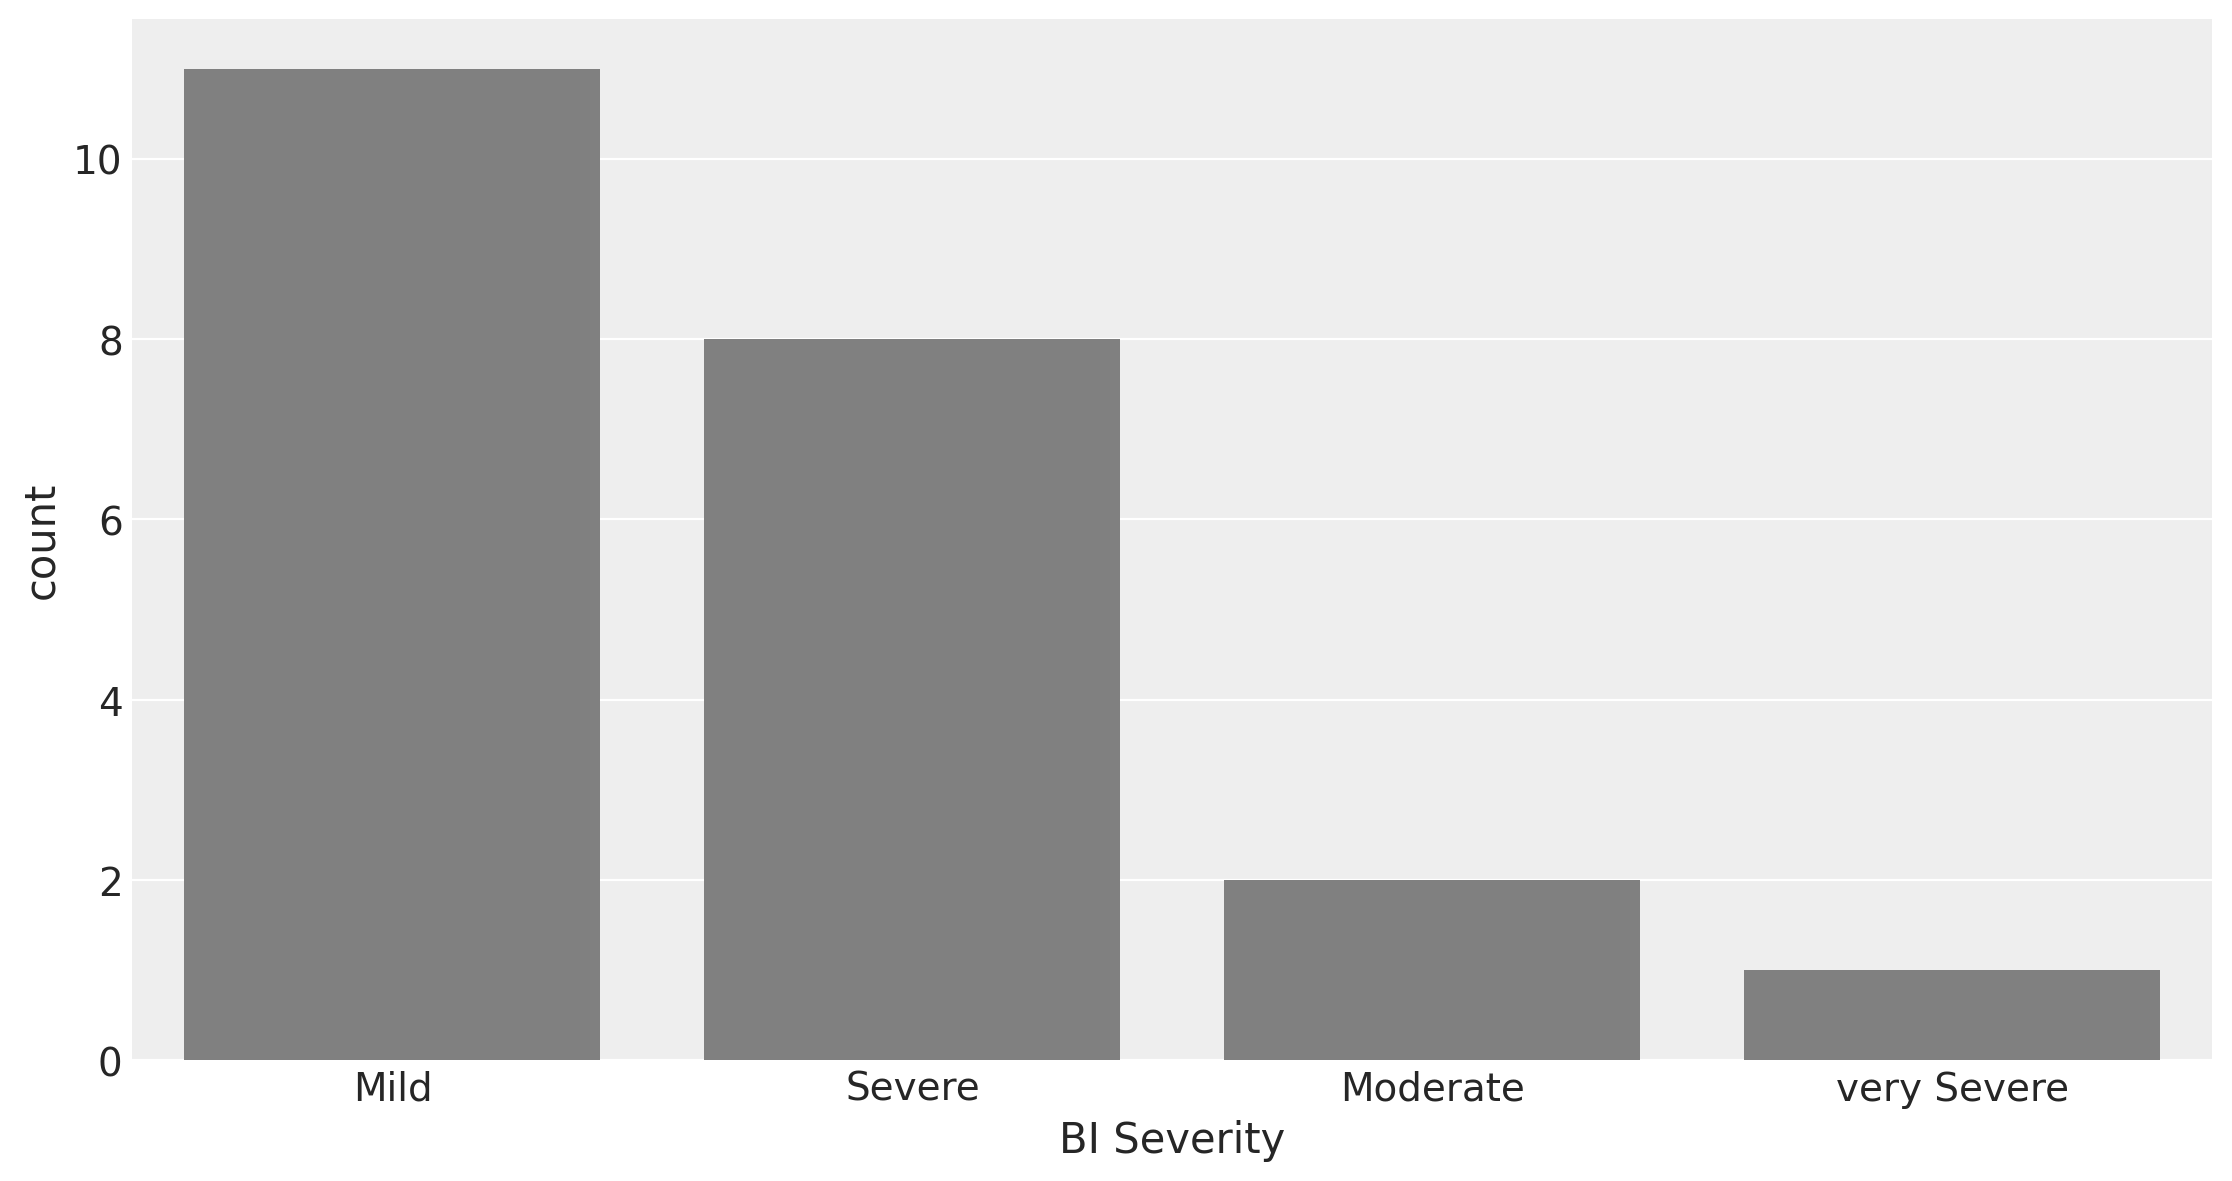

In [14]:
severity = sns.catplot(x = "BI Severity", data = dat, kind = "count", height = 6, aspect = 15/8, color = 'gray')
plt.savefig('../img/severity.png')
severity

Finally, we ask how many participants are fit to work.

In [301]:
print(f"There are {dat['Employment'].str.contains('Medically Retired|Long Term Sick Leave').sum()} participants out of {len(dat)} who are medically retired or on long term sick leave.")

There are 7 participants out of 24 who are medically retired or on long term sick leave.


Below we show the counts for impairments.

In [9]:
dat_impair = pd.concat([dat['PID'], dat.loc[:, 'Vision': 'Pain']], axis=1)
dat_impair_sum = pd.melt(dat_impair, id_vars=['PID'], var_name='Impairment', value_name='Count').query('Count == 1')

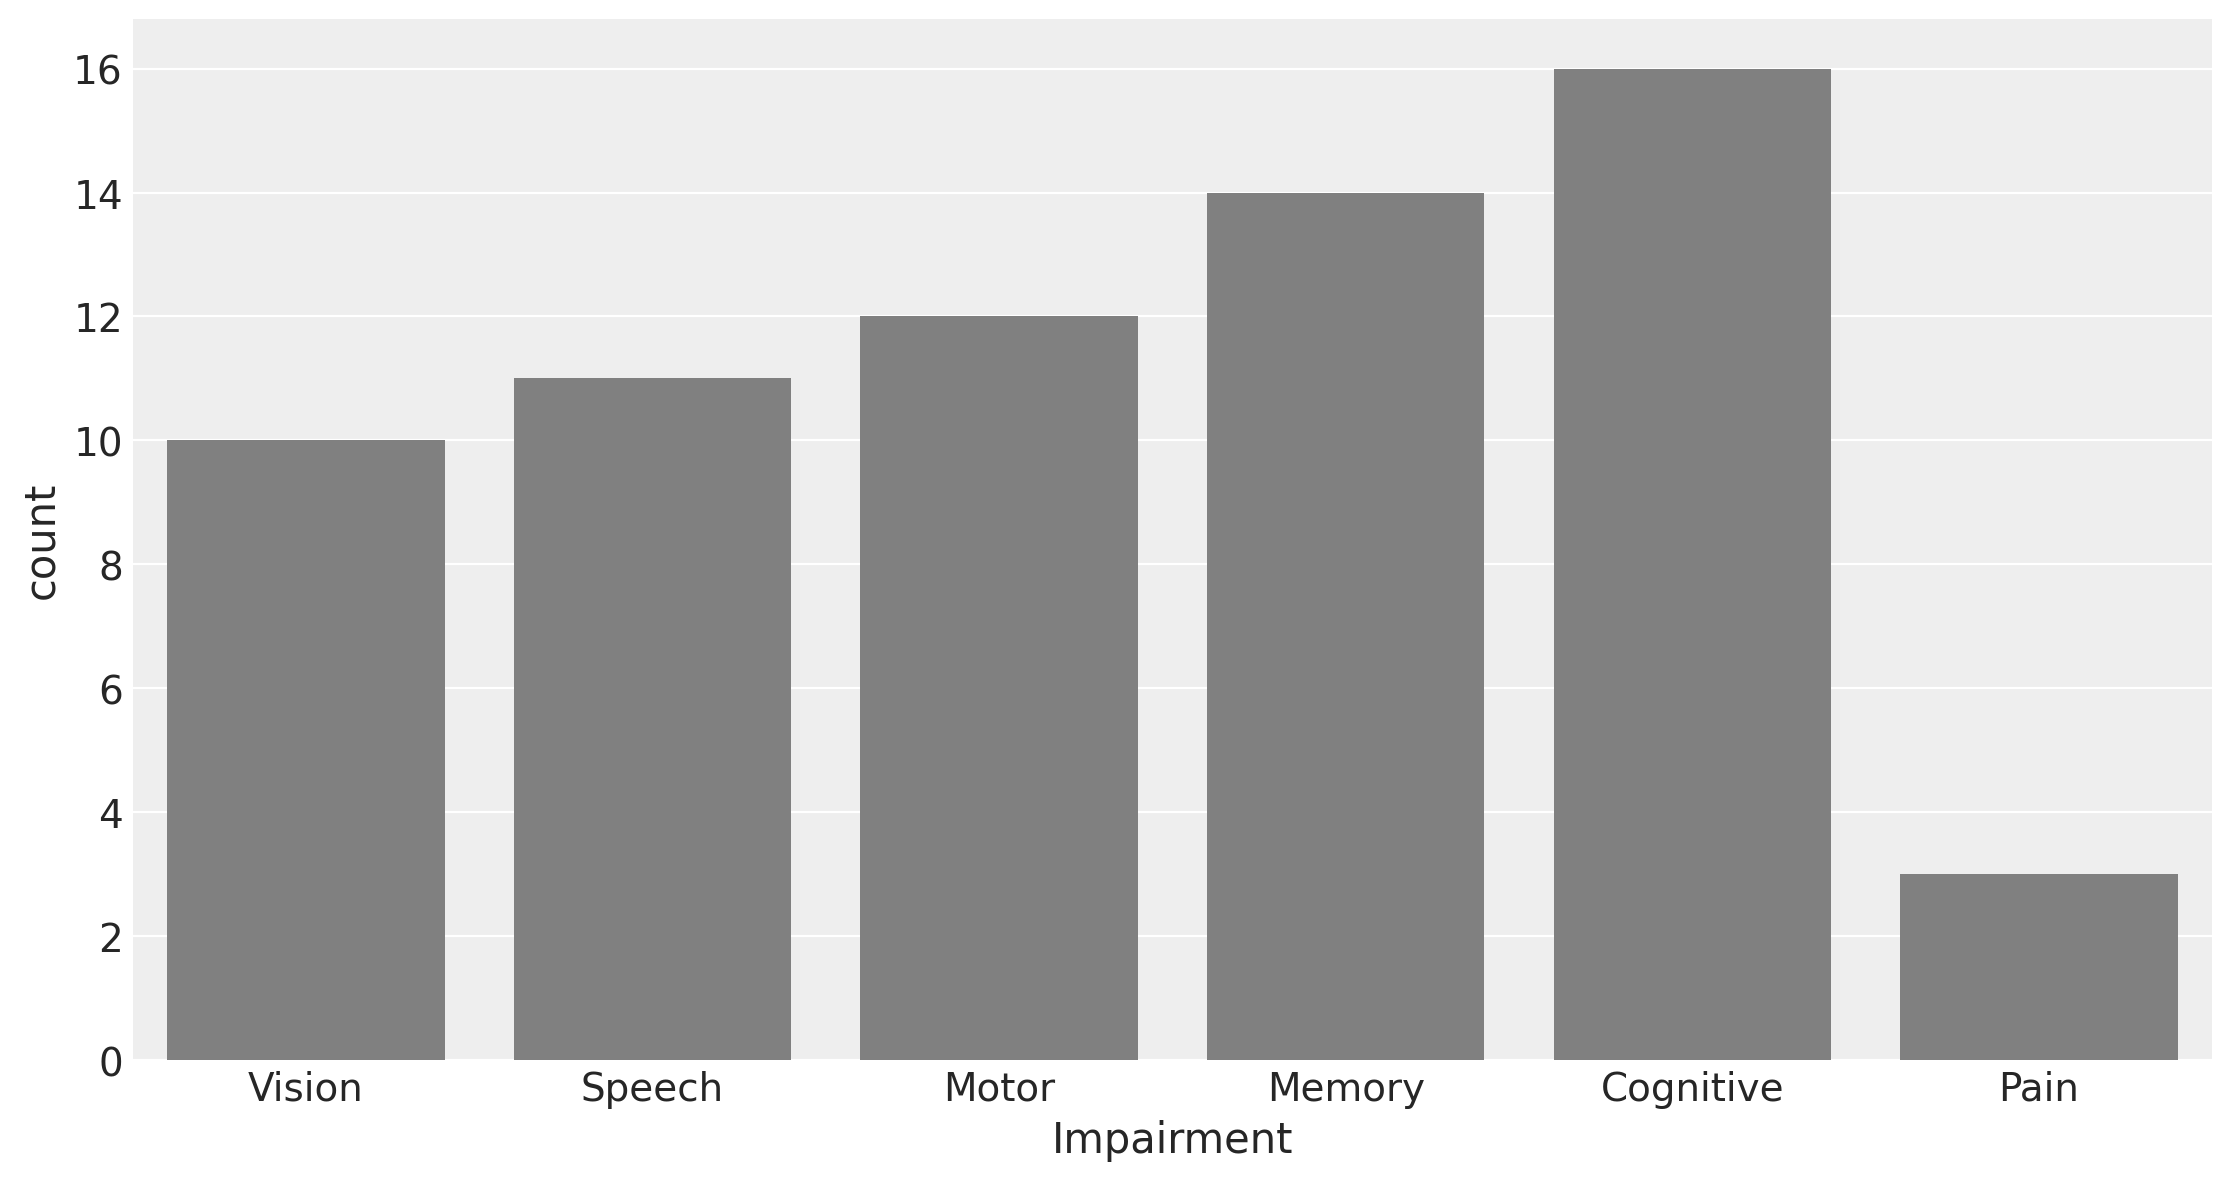

In [13]:
impairments = sns.catplot(x = "Impairment", data = dat_impair_sum, kind = "count", height = 6, aspect = 15/8, color = 'gray')
plt.savefig('../img/impairments.png')
impairments

# Model Diagnostics

Below we show the posterior predictive check for the final, reported model. Here the posterior predictive draws and the posterior predictive mean approximate the shape of the observed data, indicating that the model performs well.

<AxesSubplot:xlabel='Y / Y'>

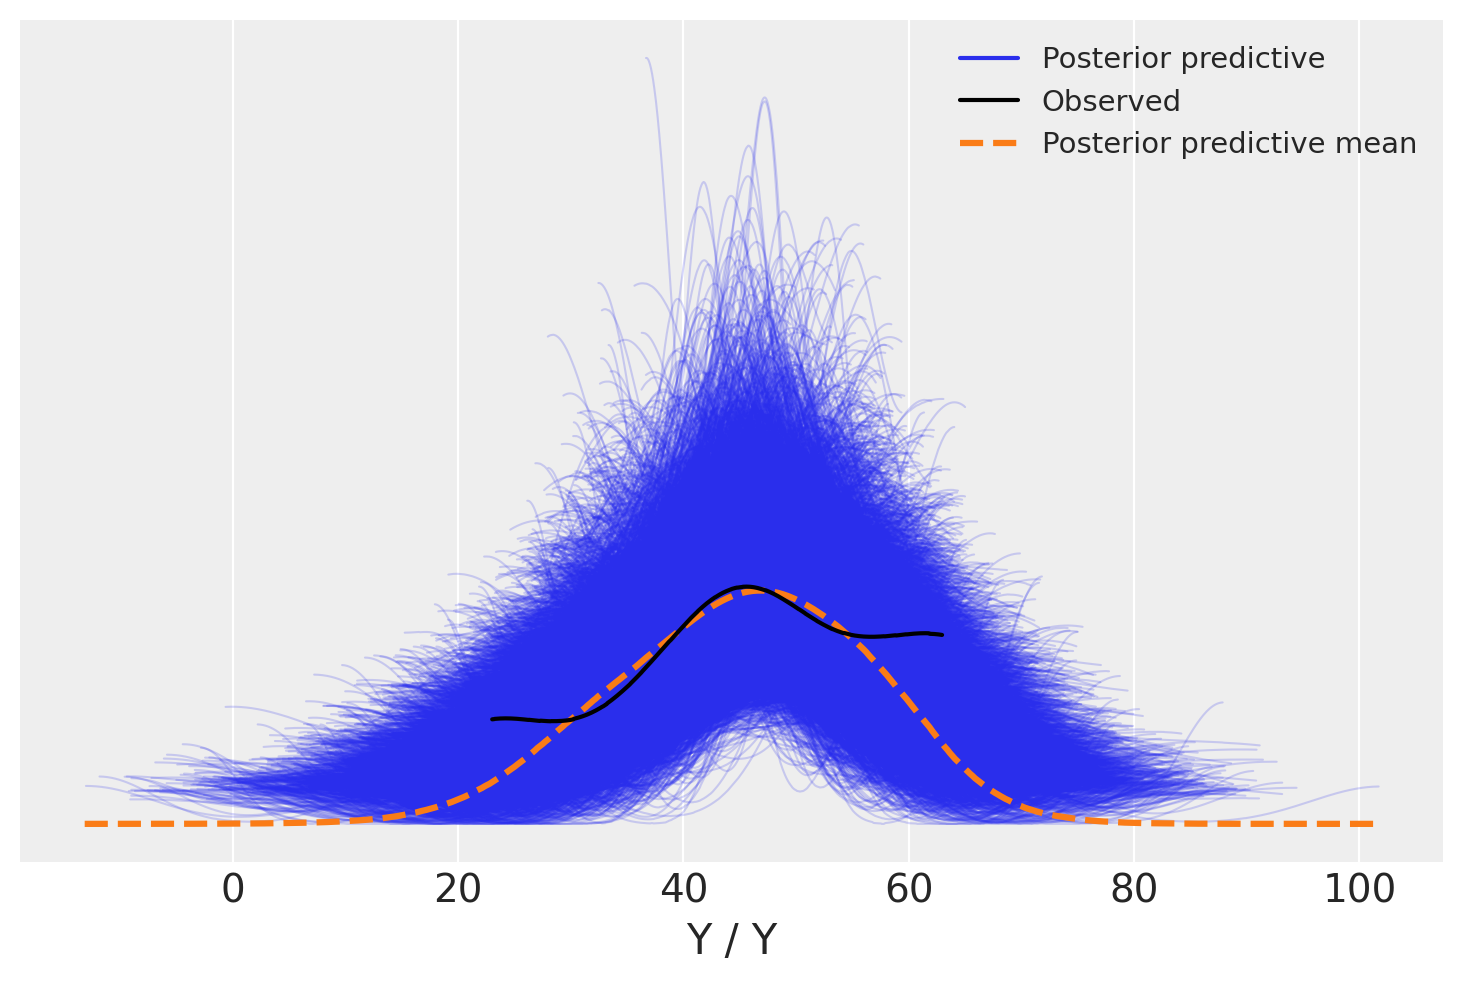

In [304]:
ppc = pm.sample_posterior_predictive(trace2, model=fit2)
az.plot_ppc(ppc)

The trace plot below also shows the marginal posterior estimates for the intercept, BRS, and sigma parameters. The trace plots (right panels) show that the chains mixed well.

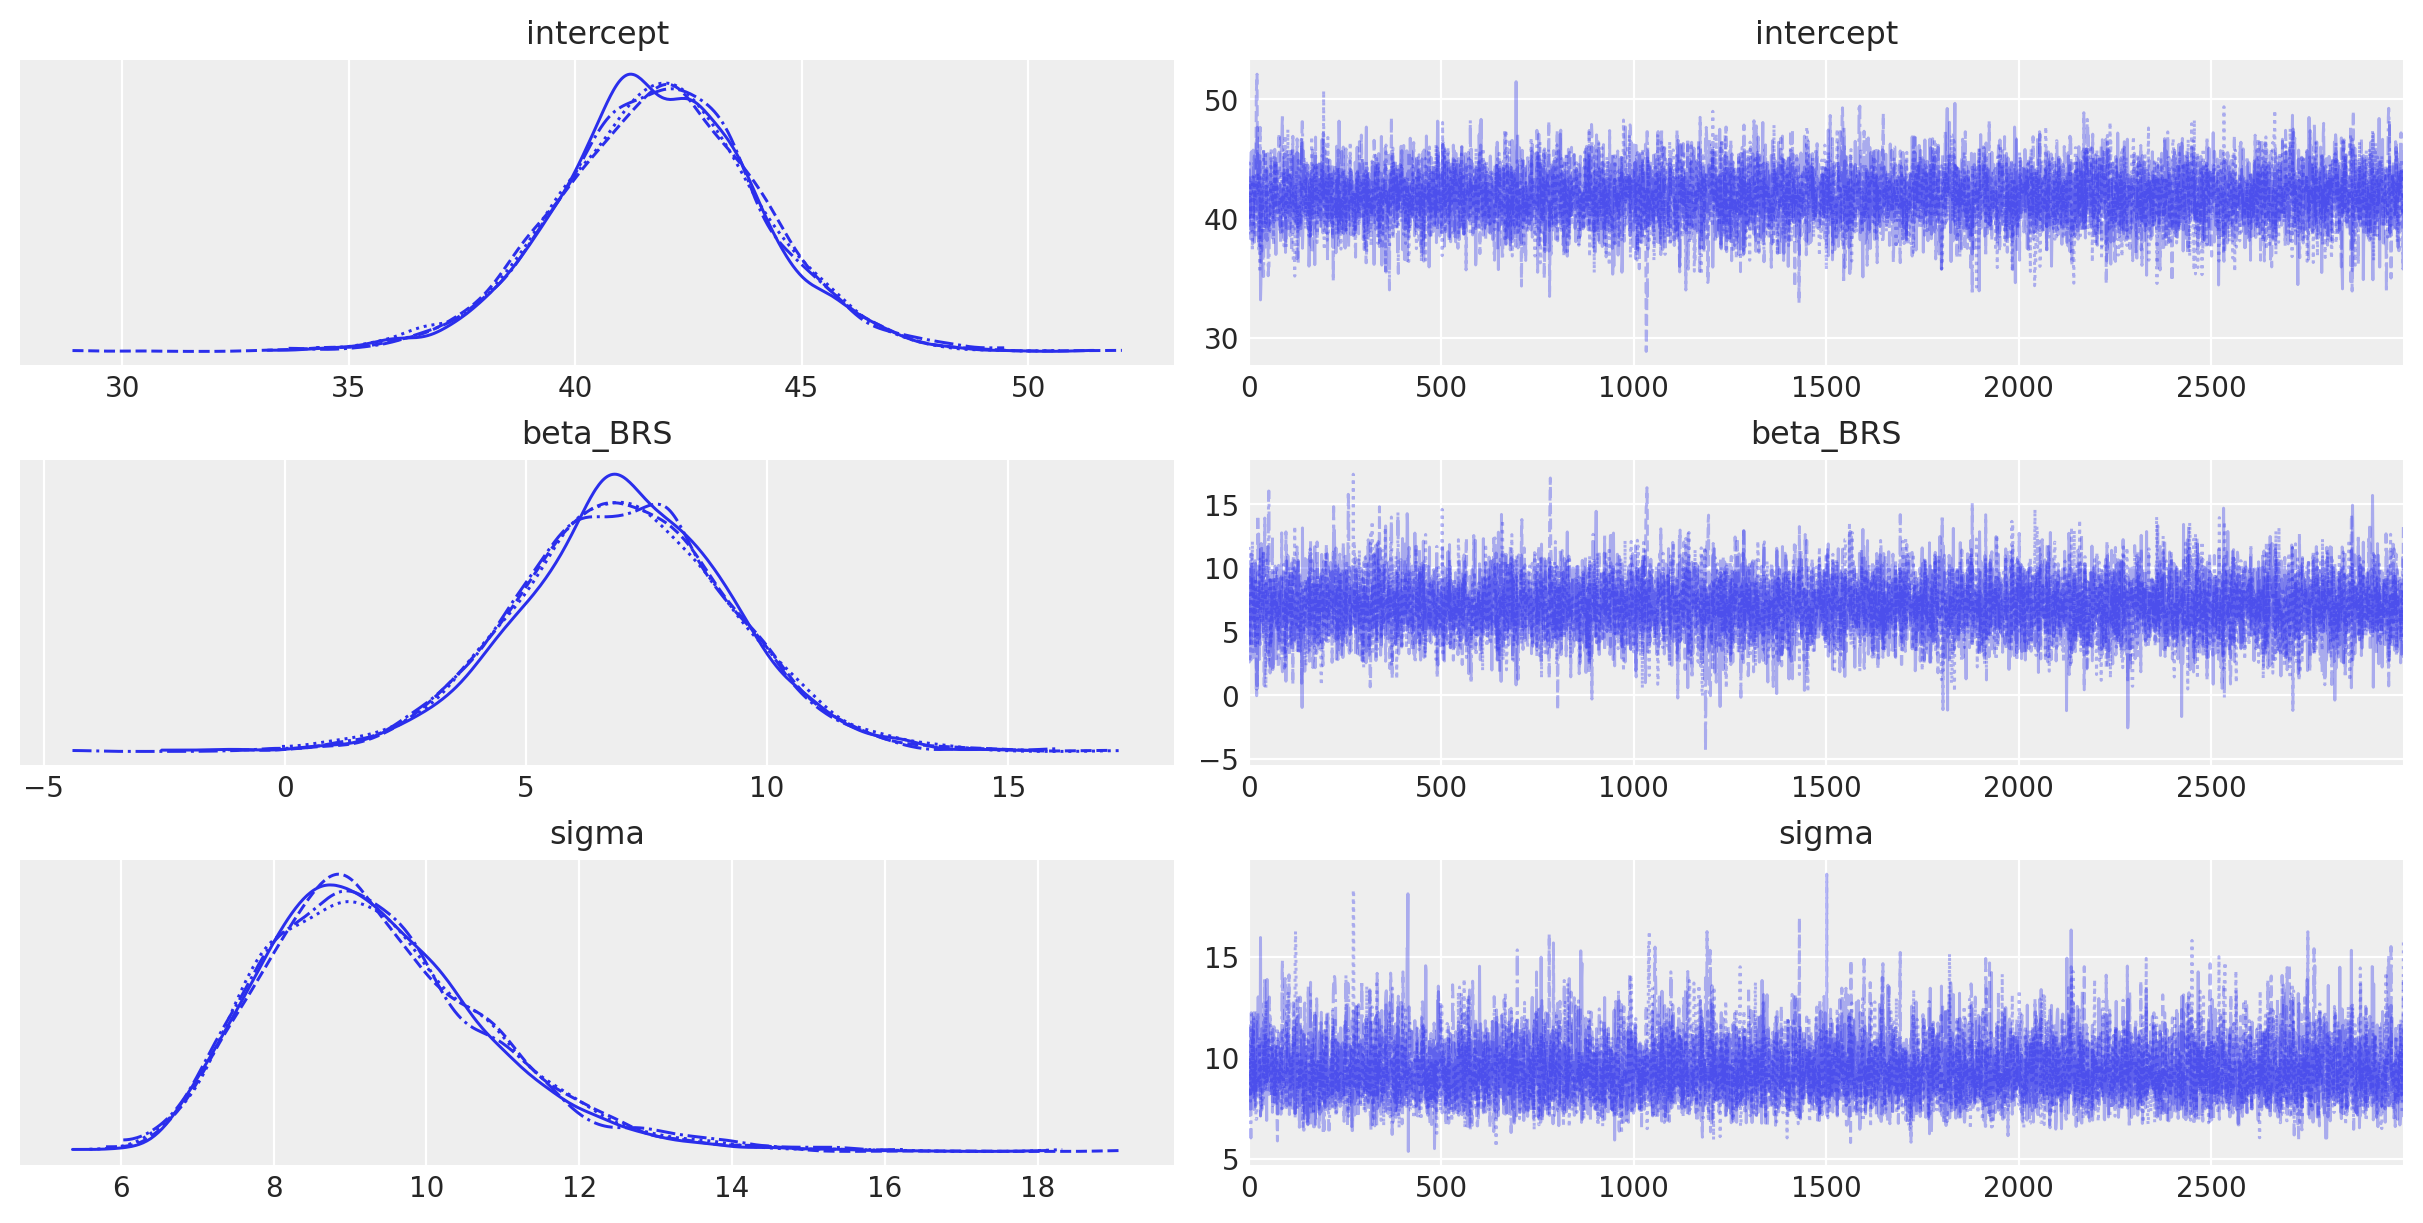

In [305]:
az.plot_trace(trace2);